In [2]:
import os
import glob
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.io import read_image
from itertools import chain

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
import seaborn as sns

import umap
import sklearn.manifold

%matplotlib inline

sns.set(style='white', rc={'figure.figsize':(12,8)})

In [3]:
# cudnn.benchmark = True
import pdb

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, annotations, transform=None):
        """
        Naive implementation:
        List all the images in the given directory (trainset/testset)
        
        For all subfolder in root:
            For each image in the subfolder:
                Add image path to the list
        """
        self.img_dir = img_dir
        self.annotations = pd.read_csv(annotations)
        self.transform = transform
        
        self.img_paths = [glob.glob(os.path.join(img_dir + '/' + subfolder, '*.jpg')) for subfolder in os.listdir(img_dir)]
        self.img_paths = list(chain.from_iterable(self.img_paths))
        
        
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        """
        Read the image, extract the pid from the image path
        Locate the corresponding label, gender, lymph_count
        And return all of them
        
        To do: what to do with DOB
        options: year, or the unix age
        """
        image = read_image(self.img_paths[idx])
        PID = self.img_paths[idx].split('/')[-2]
        label = list(self.annotations[self.annotations['ID'] == PID]['LABEL'])[0]
        gender = list(self.annotations[self.annotations['ID'] == PID]['GENDER'])[0]
#         print(type(gender)) -- bug: it should be string, but the dataloader returns a tuple ('M', )
        lymph_count = list(self.annotations[self.annotations['ID'] == PID]['LYMPH_COUNT'])[0]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, gender, lymph_count, PID

In [6]:
transform_umap = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(64),
#         transforms.Grayscale(),
        transforms.ToTensor(),
#         transforms.Normalize([0.485], [0.229]),
])

In [7]:
umap_dataset = CustomDataset(img_dir='/kaggle/input/competition-dataset/trainset',
                        annotations='/kaggle/input/competition-dataset/clinical_annotation.csv',
                        transform=transform_umap)
umap_dataloader = DataLoader(umap_dataset, batch_size=len(umap_dataset)) # for visualising the whole dataset

In [8]:
images, labels, _, _, _, = next(iter(umap_dataloader))

In [9]:
# Verify that the images are all loaded in
images.shape

torch.Size([13453, 3, 64, 64])

In [10]:
labels = labels.numpy()
labels = labels.reshape(-1,1) # from (13453,) to (13453, 1)

In [11]:
# flatten the 3 x 64 x 64 images for dimensionality reduction
# output: (13453, 12288)
print(images.shape)
images = torch.flatten(images, start_dim=1)
print(images.shape)

torch.Size([13453, 3, 64, 64])
torch.Size([13453, 12288])


In [12]:
# convert the images to numpy array from torch tensor (a remnant of using the torch dataloader)
images = images.numpy()

In [15]:
%%time
embedding = umap.UMAP(n_neighbors=100, metric='euclidean', min_dist=0.1, n_components=2).fit_transform(images)

CPU times: user 14min 15s, sys: 3.66 s, total: 14min 19s
Wall time: 4min 13s


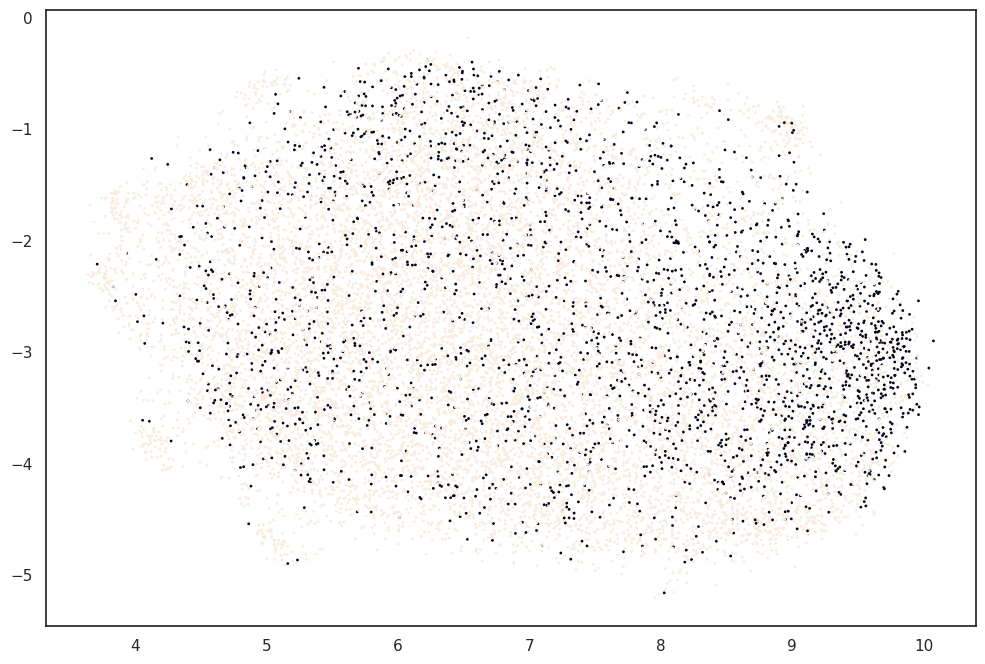

In [16]:
plt.scatter(embedding[:,0], embedding[:,1], c=labels, s=1) # cmap="Spectral"

plt.savefig('/kaggle/working/umap.png')
plt.show()

In [17]:
# Exploration of ways to generate pseudo-labels
from sklearn.neighbors import NearestNeighbors

In [18]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(embedding)

In [24]:
distances, indices = nbrs.kneighbors(embedding)

In [25]:
indices[198]

array([  198,  9529,  1423,  8027,  1332, 12177,  7791,  8315,  7846,
        7808])

In [26]:
for index in indices:
    temp = [int(labels[idx][0]) for idx in index]
    print(temp)
    break
    

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:
mean = np.mean(distances)
std = np.std(distances)

far_indices = np.argwhere(distances > abs(mean + 5*std))

In [28]:
print(distances[5])
print(indices[5])

[0.         0.03853739 0.04068339 0.04203963 0.04331386 0.04837242
 0.0591553  0.06240459 0.06317481 0.07670552]
[    5  3198 10044 12949  6879  2692 10573  9923  5987  5771]


In [29]:
print(distances[5], distances[58], mean + 5 * std, distances[5] - distances[58])

[0.         0.03853739 0.04068339 0.04203963 0.04331386 0.04837242
 0.0591553  0.06240459 0.06317481 0.07670552] [0.         0.03256696 0.0545356  0.12119994 0.12830196 0.14187807
 0.1494042  0.15848857 0.1797873  0.19739415] 0.25122941339063365 [ 0.          0.00597043 -0.01385221 -0.07916031 -0.0849881  -0.09350565
 -0.0902489  -0.09608397 -0.11661249 -0.12068862]


In [30]:
far_indices[0]

array([20,  8])

In [31]:
len(far_indices)

369

In [32]:
count = 0
for i in far_indices:
    a, b = i[0], i[1]
    if labels[a] == 0 or labels[b] == 0:
        count += 1
print(count)

52


In [57]:
embedding.shape

(13453, 3)

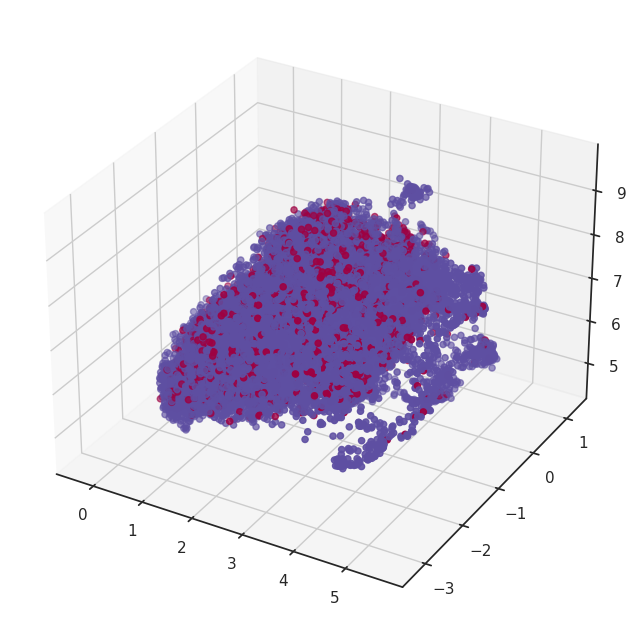

In [60]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(embedding[:, 0], embedding[:,1], embedding[:,2], c=one_d_labels, cmap='Spectral')

plt.show()

In [61]:
from sklearn.cluster import KMeans

In [91]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(embedding)

In [92]:
k_labels = kmeans.labels_

In [93]:
locs = np.where(k_labels == 0)[0]

In [94]:
len(np.where(labels == 0)[0])

2592

In [95]:
len(locs)

7365

In [70]:
len(np.where(kmeans.labels_ == 1))

1